# Synthetic Data Exploration

In this file, I will be implementing different ecological spread models to generate synthetic geospatial population data for invasive species modeling. Per our conversation on 3/6/24, Professor Brantingham recommended that we implement the **Lotka-Volterra Model** and the **Tilman model** to understand competition between two species. I will be implementing these as a starting point.

## Lotka-Voltera Model

This model explores how competition influences the abundance of two competing species in a region where the specific competitive mechanism does not need to be known. This model originated in modeling predator-prey dynamics, which translates very well to our invasive species context where invasive species are the predators.

To implement this model, we will be using the following tutorial to get started: https://softinery.com/blog/lotka-volterra-model-and-simulation/, that breaks down the implemntation into x parts:
- imports
- defining the optimization equations
- initializing the environment
- solving the environment over time
- plotting the results

Note that this tutorial works on a specific region and the number of predator and prey species at a given timestep. For our purposes, we want a geospatial map of related points where these numbers are calculated to create a heat-map of predator locations. I found this paper that explicitly discusses L-V heatmaps in section 4.4.3: https://ppgfis.ufba.br/sites/ppgfis.ufba.br/files/rafael_menezes_msc_dissertationupdated.pdf. The general theoretic idea is to use a specified aggregation function to gather the numbers of predators at a certain timestep for a given unit area of a region and to shade that region accordingly. As the original repo from the paper is dead, I found some potential github leads:
- https://github.com/r-menezes/SpatialPreyPred/tree/main: seems to generate vector fields of species
- https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py: seems to generate LV data, not sure about expansion to heatmaps

## Simple, Non-spatial Lotka-Volterra Models

In [15]:
# data generation. Based on work from https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py

# imports
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
import random 

#Constants: Simulation Parameters
ALPHA = 2 / 3
BETA = 4 / 3
GAMMA = 1
DELTA = 1

# lotka-volterra model dynamics. Defines the partials in terms of the simulation constants
# CATHERINE: vector y holds [prey(t), predator(t)] and vector out returns the equations of L-V
def dynamics(t, y):
    """Lotka Volterra model"""
    out = np.zeros_like(y)
    out[0] = y[0] * (ALPHA - BETA * y[1])
    out[1] = y[1] * (DELTA * y[0] - GAMMA)
    return out


'''generate(): creates np file simulating multiple trajectories of Lotka Volterra's system. The args are:
    num_traj: number of trajectories to simulate. default 200
    len_traj: length of a trajectory (in seconds). default 25
    pts_per_sec: number of points per second. default 40
    save_loc: where to save created files
'''
def generate(num_traj=200,len_traj=25, pts_per_sec=100, save_loc='../Data/val.npy', prey_range=(1, 5), predator_range=(1, 3)):
    dataset = np.zeros((num_traj, 2, len_traj * pts_per_sec))  # That will store each simulation
    t_span = [0, len_traj]
    t_eval = np.linspace(0, len_traj, len_traj * pts_per_sec)  # Time vector

    # Change this line to configure how much you downsample the data, and the final time range
    downsample_rate = int(len(t_eval) / (len_traj * pts_per_sec))
    idx = np.arange(0, len(t_eval), downsample_rate)

    for k in tqdm(range(num_traj)):
        # Generate random initial values for prey and predator populations within the specified ranges
        y0 = np.array([random.uniform(*prey_range), random.uniform(*predator_range)])
        # sol.y has shape (2, 2500) with one row representing the prey(t) function and the other representing the predator(t)function 
        sol = solve_ivp(dynamics, y0=y0, t_span=t_span, t_eval=t_eval)
        dataset[k] = sol.y[:, idx]

    np.save(save_loc, dataset)

generate()

100%|██████████| 3/3 [00:00<00:00, 75.52it/s]

(2, 2500)
(2, 2500)
(2, 2500)
(2, 2500)
(2, 2500)
(2, 2500)
(3, 2, 2500)


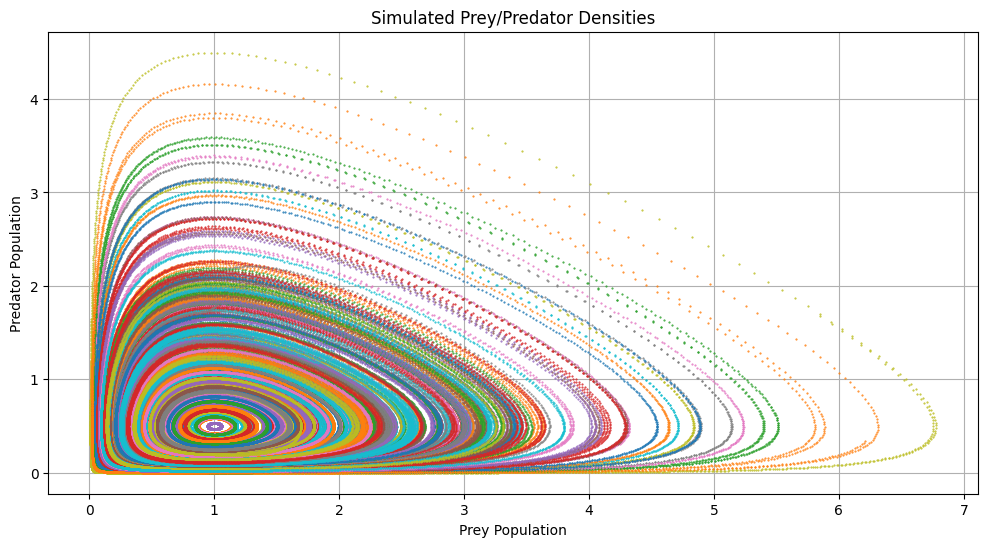

In [20]:
# intuition check on simulated data
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file containing the simulation data
data = np.load('../Data/val.npy')

# Extract prey and predator population data
prey_data = data[:, 0, :]
predator_data = data[:, 1, :]

# Plot the predator locations for each trajectory
plt.figure(figsize=(12, 6))
plt.title('Simulated Prey/Predator Densities')

# Plot each trajectory separately
for traj_index in range(len(prey_data)):
    plt.plot(prey_data[traj_index], predator_data[traj_index], '.', markersize=1)

plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.grid(True)
plt.show()

## Spatial Lotka-Voltera Model, Inspired by [Prof. Brantingham's paper on gang violence](https://www.researchgate.net/profile/P-Brantingham/publication/263387106_The_Ecology_of_Gang_Territorial/links/5e98f480299bf13079a1d325/The-Ecology-of-Gang-Territorial.pdf) 

The Lotka-Volterra Model above only models the density of predator and prey through time, but doesn't model the density of predator and prey through time AT a certain spatial location (x-y coordinate); this is important for our project as our goal is to identify best locations to lay down traps and how predator/prey densities change in response to traps. 

In his paper linked above, Prof. Brantingham developed a sptially explicit version of the Lotka-Volterra competition model (see page 856 - 857) to study the distribution of between-gang violent events. We explore and adapt this model to our own use case below. Note that this Lotka-Volterra model requires us to solve a system of PDEs involving second-order partial derivatives. 

Here are two possible avenues to explore a system of PDEs involving second-order partial derivatives: 
- Define extra variables 
- Discretize 
* will elaborate on this once I read some more stuff
